# Final project on 'Data Science' - HIT

### Writing the project: <br/>
Nave Shimoni  <br/>
Itay galili

### Research question:  <br/>
Is it possible to anticipate the decrease in car's value in 5 years based on ZapCars?

# Crawling

In [5]:
#from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
import time
import json
import requests
import re
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import linear_model
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer


### Test before performing <br/>
In testing before the crawling we saw that there are about 4700 cars, each HTML page on the site contains 20 cars, so about 236 iterations are required for each page, in addition we saw that the difference between pages is its URL extension (the site worked differently at the beginning of the project and there was a need for selinium, but after a change - we made adjustments)

In [2]:
base_url = "https://www.zapcars.co.il/"
tab_results = []

for page_number in tqdm(range(1, 236)):
    url = base_url + "cars/?page=" + str(page_number)
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        tab_results.extend(soup.find_all("div", attrs={"class": "resultsListItem"}))
    else:
        print("Failed to fetch page", page_number)

print(tab_results)

100%|██████████| 235/235 [05:06<00:00,  1.30s/it]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Let's see how many URLs of HTML pages for cars we managed to collect:

In [3]:
print(len(tab_results))



4700


In [4]:
links_to_pages = []
for tag in tab_results:
    a_tag = tag.find("a")
    if a_tag is not None and 'href' in a_tag.attrs:
        links_to_pages.append(a_tag['href'])

links_to_pages = [base_url + link for link in links_to_pages]
print(links_to_pages)

with open("links_to_pages.json", "w") as f:
    json.dump(links_to_pages, f)

['https://www.zapcars.co.il//listing/d63f1ac8-bdf5-4e3a-ba9e-d1c6212f0245/', 'https://www.zapcars.co.il//listing/d09861c7-3bf8-46b3-8498-dfa28c8259a1/', 'https://www.zapcars.co.il//listing/b2cf2b3c-7639-445c-8c82-8e553d0992b4/', 'https://www.zapcars.co.il//listing/d6b75a02-5cd1-438d-a2a0-431a9f5db707/', 'https://www.zapcars.co.il//listing/130268fe-b9f5-41fd-b279-fde3f0bbc7e7/', 'https://www.zapcars.co.il//listing/613945c7-81d9-48a4-9553-44e2a17ff23b/', 'https://www.zapcars.co.il//listing/d587cfd6-2edd-4d10-97c1-f2b065117ed9/', 'https://www.zapcars.co.il//listing/03d90abc-d674-4b56-b7e9-18ef4b32d974/', 'https://www.zapcars.co.il//listing/e9139b09-c6a4-4004-8b9f-204f91896a9d/', 'https://www.zapcars.co.il//listing/ce9c774e-8157-42a4-803d-4a0d16864179/', 'https://www.zapcars.co.il//listing/240aaedd-4934-4aa0-a943-9a80f372cc9e/', 'https://www.zapcars.co.il//listing/372cc3f9-32c1-482c-b729-049102b853d9/', 'https://www.zapcars.co.il//listing/5350f405-d840-49ab-948e-b86d5e4b0e3a/', 'https://ww

Once we have received all the addresses of each page, we will go through each page and take the relevant information from it. We saw that there are 12 columns of information that can be a component of a car price. <br/>
note:
* We checked that the vehicle still existed, because it happened to us that a car page was closed while working and the running stopped (with response = 200).
* We decided to perform health checks on the resulting elements at this stage (element type, end cases that cost us, transfer from string to int, etc.).
* We used 'tqdm' to control the workflow (which took almost an hour!).


In [11]:
company=[]
car_type=[]
year=[]
engine_volume=[]
km=[]
hand=[]
gear_box=[]
color=[]
current_owner=[]
price=[]
gas=[]
horse_power=[]

for url in tqdm(links_to_pages):
    response = requests.get(url)
    if response.ok:
        soup2 = BeautifulSoup(response.content)
        mtags_span=soup2("span")

        #year
        mtag1=re.findall('\d+', mtags_span[15].get_text())
        if mtag1:
            year.append(int(mtag1[0]))
        else:
            year.append(None)

        #color
        mtag2=soup2.find("div",attrs={"id":"carColor"})
        if mtag2:
            mtag2 = mtag2.get_text().strip()
            color.append(mtag2)
        else:
            color.append(None)

        #company
        mtag3=mtags_span[10].get_text().strip()
        if mtag3:
            company.append(mtag3)
        else:
            company.append(None)

        #car_type
        mtag4=mtags_span[12].get_text().strip().lstrip('\u200f')
        if mtag4:
            car_type.append(mtag4)
        else:
            car_type.append(None)

        #engine_volume
        mtag5=soup2.find("div",attrs={"id":"carDetailsEngineVolume"})
        if mtag5:
            mtag5 = int(re.sub("[^0-9]", "", mtag5.get_text()))
            engine_volume.append(mtag5)
        else:
            engine_volume.append(None)

        #hand
        mtag6=soup2.find("div",attrs={"id":"carDetailsHand"})
        isNew = 1 if "רכב חדש" in mtag6.get_text() else 0
        mtag6 = re.sub("[^0-9]", "", mtag6.get_text().strip())
        if mtag6:
            hand.append(int(mtag6))
        else:
            hand.append(None)

        #km
        if isNew==0:
            mtag7 = re.sub("[^0-9]", "", mtags_span[16].get_text())
            if mtag7:
                km.append(int(mtag7))
            else:
                km.append(None)    
        else:
            mtag7=0
            km.append(mtag7)

        #gear_box
        mtag8=soup2.find("div",attrs={"id":"carDetailsAutomatic"})
        if mtag8:
            mtag8 = mtag8.get_text().strip()
            gear_box.append(mtag8)
        else:
            gear_box.append(None)

        #current_owner
        mtag9=soup2.find("div",attrs={"id":"carOnershipType"})
        if mtag9:
            mtag9 = mtag9.get_text().strip()
            current_owner.append(mtag9)
        else:
            current_owner.append(None)

        #gas
        mtag10=soup2.find("div",attrs={"id":"carDetailsGasType"})
        if mtag10:
            mtag10 = mtag10.get_text().strip()
            gas.append(mtag10)
        else:
            gas.append(None)

        #price
        mtag11=soup2.find("div",attrs={"id":"carPrice"})
        if mtag11:
            mtag11 = int(re.sub("[^0-9]", "", mtag11.get_text()))
            price.append(mtag11)
        else:
            price.append(None)

        #horse_power
        mtag12=soup2.find("div",attrs={"id":"carDetailsHorsepower"})
        if mtag12:
            mtag12 = int(mtag12.get_text())
            horse_power.append(mtag12)
        else:
            horse_power.append(None)



100%|██████████| 4700/4700 [59:55<00:00,  1.31it/s]   


In [ ]:
df=pd.DataFrame({"company":company,
                 "car type":car_type,
                 "year":year,
                 "engine volume":engine_volume,
                 "km":km,
                 "hand":hand,
                 "gear box":gear_box,
                 "color":color,
                 "current owner":current_owner,
                 "price":price,"gas":gas,
                 "horse power":horse_power})

df.to_csv('data_frame.csv', index=False)

Mazel Tov! We have a data frame with 12 columns and 4699 rows, in total we have 56,400 data units. <br/> We will save everything on a CSV file for use at other times (so that we don't have to wait all the time again).

In [138]:
#This line below is the temporary run in order to get the df
df=pd.read_csv("data_frame.csv")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None) 
df

company           car type  year  engine volume      km  hand  \
0                 הונדה               HR-V  2019           1498  138054     1   
1              מיצובישי              אטראז  2020           1193   34969     1   
2                 אאודי                 A6  2017           1798  118000     3   
3                 מאזדה                  3  2020           1998   76677     1   
4                 מאזדה                  2  2023           1496       0     1   
5                שברולט          אקווינוקס  2019           1490   44000     1   
6                  פיאט                500  2023              0       0     1   
7                 סקודה            אוקטביה  2019            999  123264     1   
8              מיצובישי         ספייס סטאר  2021           1193   23727     1   
9                   קיה             פיקנטו  2020           1248   65676     1   
10                סקודה             קודיאק  2018           1968   98000     1   
11               יונדאי              אקסנט  2020           1368   82318     1   
12               יונדאי                I10  2021           1197   37251     1   
13               שברולט              ספארק  2020           1399   72093     1   
14                 סיאט               לאון  2016           1798  158000     2   
15                  קיה             פיקנטו  2019           1248  107892     1   
16                  קיה            ספורטאז  2017           1999  112265     1   
17                 סיאט             איביזה  2018            999  107724     1   
18               יונדאי                I10  2020           1197  111581     1   
19                פיג'ו               5008  2020           1199   59660     1   
20               יונדאי                I20  2020            998   96858     1   
21                  קיה             פיקנטו  2021           1248   67445     1   
22               יונדאי              טוסון  2023           1598       0     1   
23               שברולט             קפטיבה  2017           1956   74000     2   
24               סובארו            אימפרזה  2018           1600  168500     2   
25             מיצובישי         ספייס סטאר  2021           1193   24731     1   
26               יונדאי             איוניק  2020           1580  103285     1   
27              קרייזלר              רנגלר  2021           1995   25000     2   
28                  קיה             פיקנטו  2020           1248   86957     1   
29                אאודי                 Q3  2016           1984  153000     1   
30                פיג'ו               2008  2018           1199   66450     1   
31                סקודה             קודיאק  2019           1968   95000     1   
32                 סיאט               לאון  2017           1984  100000     1   
33               יונדאי             איוניק  2020           1580  108000     1   
34               טויוטה             קורולה  2019           1798  116890     1   
35               טויוטה             קורולה  2019           1798   90498     1   
36                מרצדס                CLA  2023           1332       0     1   
37               יונדאי              טוסון  2018           1999   64815     1   
38               יונדאי             איוניק  2019           1580  113168     1   
39              סיטרואן                 C3  2019           1199   44150     2   
40               סובארו                 XV  2018           1600   98000     1   
41                פיג'ו               3008  2020           1499  105777     2   
42                סקודה              סקאלה  2020            999   81496     1   
43               שברולט          אקווינוקס  2017           1490   50000     1   
44                פיג'ו               3008  2020           1598   50258     1   
45             מיצובישי             אקליפס  2019           1499   32316     1   
46                מרצדס                GLA  2023           1332       0     1   
47               טויוטה             קורולה  2020           1798   53377     1   
48                 ג'יפ              רנגלר  202

In [139]:
df.shape

(4699, 12)

# Data handling <br/>
Before we begin, here are a number of treatments that have already been performed:
* Any element that has no data - we put "None" instead.
* We saw that new cars do not indicate the vehicle's km, so we proactively put 0 (note the "isNew" flag in the hand number).
* We performed casting on strings and turned them into int.

Let's start with simple data verification commands.

In [140]:
df.describe(include="all")

company car type    year  engine volume        km    hand  gear box  \
count     4699     4699 4699.00        4699.00   4699.00 4699.00      4699   
unique      50      317     NaN            NaN       NaN     NaN         2   
top        קיה  אוקטביה     NaN            NaN       NaN     NaN  אוטומטית   
freq       657      265     NaN            NaN       NaN     NaN      4638   
mean       NaN      NaN 2019.35        1592.01  77694.04    1.18       NaN   
std        NaN      NaN    1.81         561.19  42871.69    0.49       NaN   
min        NaN      NaN 2005.00           0.00      0.00    0.00       NaN   
25%        NaN      NaN 2019.00        1248.00  50011.50    1.00       NaN   
50%        NaN      NaN 2019.00        1499.00  80000.00    1.00       NaN   
75%        NaN      NaN 2020.00        1977.00 105000.00    1.00       NaN   
max        NaN      NaN 2023.00        6162.00 499999.00    7.00       NaN   

           color current owner     price    gas  horse power  
count       4699          4695   4699.00   4699      4699.00  
unique        64             5       NaN      5          NaN  
top     שנהב לבן          חברה       NaN  בנזין          NaN  
freq        1318          1362       NaN   3972          NaN  
mean         NaN           NaN 130006.13    NaN       148.70  
std          NaN           NaN  87389.76    NaN        59.73  
min          NaN           NaN   9900.00    NaN        45.00  
25%          NaN           NaN  84831.00    NaN       115.00  
50%          NaN           NaN 109180.00    NaN       141.00  
75%          NaN           NaN 139154.50    NaN       159.00  
max          NaN           NaN 999000.00    NaN       551.00

The ranges of numbers indicated here are appropriate and logical (for example, it makes sense that vehicle years range from 2005 to 2023)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4699 entries, 0 to 4698
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   company        4699 non-null   object
 1   car type       4699 non-null   object
 2   year           4699 non-null   int64 
 3   engine volume  4699 non-null   int64 
 4   km             4699 non-null   int64 
 5   hand           4699 non-null   int64 
 6   gear box       4699 non-null   object
 7   color          4699 non-null   object
 8   current owner  4695 non-null   object
 9   price          4699 non-null   int64 
 10  gas            4699 non-null   object
 11  horse power    4699 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 440.7+ KB


In [142]:
df.isnull().sum()

company          0
car type         0
year             0
engine volume    0
km               0
hand             0
gear box         0
color            0
current owner    4
price            0
gas              0
horse power      0
dtype: int64

There are 'NaN' in 'current owner', and you can also see that this column is relatively the 'most problematic': <br/>
(We will turn each NaN into a "not specify").

In [143]:
df["current owner"].fillna('-',inplace=True)
df['current owner'] = df['current owner'].replace('-', 1)
replace_map = {'חברה':3, "ליסינג":2, "השכרה":4, "פרטי":5}
df.replace(replace_map, inplace=True)

df['current owner'].value_counts()

3    1362
2    1191
1    1123
5     775
4     248
Name: current owner, dtype: int64

There are a lot of ' - ' in this column (1119).

In [144]:
df['company'] = df['company'].replace('קיה', 'KIA')
df['company'] = df['company'].replace('סקודה', 'Skoda')
df['company'] = df['company'].replace('יונדאי', 'Hyudai')
df['company'] = df['company'].replace('מיצובישי', 'Mitsubishi')
df['company'] = df['company'].replace("פיג'ו", 'Peugoet')
df['company'] = df['company'].replace('טויוטה', 'Toyota')
df['company'] = df['company'].replace('אאודי', 'Audi')
df['company'] = df['company'].replace('שברולט', 'Chevrolet')
df['company'] = df['company'].replace('סיאט', 'Seat')
df['company'] = df['company'].replace('ניסאן', 'Nissan')
df['company'] = df['company'].replace('מאזדה', 'Mazda')
df['company'] = df['company'].replace('סיטרואן', 'Citroen')
df['company'] = df['company'].replace('מרצדס', 'Marcedes')
df['company'] = df['company'].replace('ב מ וו', 'BMW')
df['company'] = df['company'].replace('פולקסווגן', 'Volkswagen')
df['company'] = df['company'].replace('רנו', 'Renault')
df['company'] = df['company'].replace('סובארו', 'Subaru')
df['company'] = df['company'].replace("ג'יפ", 'Jeep')
df['company'] = df['company'].replace("אם.ג'י - ‏MG", 'MG')
df['company'] = df['company'].replace('פורד', 'Ford')
df['company'] = df['company'].replace('לנד רובר', 'Land Rover')
df['company'] = df['company'].replace('וולבו', 'Volvo')
df['company'] = df['company'].replace("צ'רי", 'Chery')
df['company'] = df['company'].replace('אופל', 'Opel')
df['company'] = df['company'].replace('פיאט', 'Fiat')
df['company'] = df['company'].replace('קאדילאק', 'Cadillac')
df['company'] = df['company'].replace("דאצ'יה", 'Dacia')
df['company'] = df['company'].replace('סוזוקי', 'Suzuki')
df['company'] = df['company'].replace('טסלה', 'Tesla')
df['company'] = df['company'].replace('יגואר', 'Jaguar')
df['company'] = df['company'].replace('הונדה', 'Honda')
df['company'] = df['company'].replace('אלפא רומיאו', 'Alfa Romeo')
df['company'] = df['company'].replace('איסוזו', 'Isuzu')
df['company'] = df['company'].replace('קרייזלר', 'Chrysler')
df['company'] = df['company'].replace('לקסוס', 'Lexus')
df['company'] = df['company'].replace('די. אס - ‏DS', 'DS')
df['company'] = df['company'].replace('אינפיניטי', 'Infiniti')
df['company'] = df['company'].replace('סמארט', 'Smart')
df['company'] = df['company'].replace('מזראטי', 'Maserati')
df['company'] = df['company'].replace('גילי', 'Gili')
df['company'] = df['company'].replace('מיני', 'Mini')
df['company'] = df['company'].replace("ג'י.איי.סי - ‏GAC", 'GAC')
df['company'] = df['company'].replace('מקסוס', 'Maxus')
df['company'] = df['company'].replace('בי.ווי.די - ‏BYD', 'BYD')
df['company'] = df['company'].replace("דודג'", 'Dodge')
df['company'] = df['company'].replace("אף אי דאבל יו", 'FEW')
df['company'] = df['company'].replace("סרס", 'Seres')
df['company'] = df['company'].replace("סאנגיונג", 'Ssangyong')
df['company'] = df['company'].replace("איווייס", 'Aiways')
df['company'] = df['company'].replace("פורשה", 'Porsche')

print(df['company'].value_counts())

KIA           657
Skoda         640
Hyudai        474
Mitsubishi    384
Peugoet       322
Toyota        268
Audi          246
Chevrolet     192
Seat          176
Nissan        167
Mazda         157
Citroen       113
Marcedes      102
BMW            87
Volkswagen     71
Renault        68
Subaru         61
Jeep           49
MG             38
Ford           36
Land Rover     33
Volvo          30
Chery          28
Opel           27
Fiat           27
Cadillac       25
Dacia          25
Suzuki         24
Tesla          23
Jaguar         21
Honda          20
Alfa Romeo     19
Isuzu          13
Chrysler       12
Lexus          12
DS             11
Infiniti        7
Porsche         6
Smart           5
Maserati        5
Gili            4
Mini            3
GAC             3
Maxus           2
BYD             1
Dodge           1
FEW             1
Seres           1
Ssangyong       1
Aiways          1
Name: company, dtype: int64


In [145]:
df['car type'] = df['car type'].replace('אוקטביה', 'Octavia')
df['car type'] = df['car type'].replace('קורולה', 'Corolla')
df['car type'] = df['car type'].replace('קודיאק', 'Kodiak')
df['car type'] = df['car type'].replace('פיקנטו', 'Picanto')
df['car type'] = df['car type'].replace('אאוטלנדר', 'Outlander')
df['car type'] = df['car type'].replace('ספורטאז', 'Sportage')
df['car type'] = df['car type'].replace('נירו', 'Niro')
df['car type'] = df['car type'].replace('ספארק', 'Spark')
df['car type'] = df['car type'].replace('איוניק', 'Ioniq')
df['car type'] = df['car type'].replace('טוסון', 'Tucson')
df['car type'] = df['car type'].replace('קשקאי', 'Qashqai')
df['car type'] = df['car type'].replace('קארוק', 'Karoq')
df['car type'] = df['car type'].replace('ארונה', 'Arona')
df['car type'] = df['car type'].replace('סטוניק', 'Stonic')
df['car type'] = df['car type'].replace('אטראז', 'Attrage')
df['car type'] = df['car type'].replace('סופרב', 'Superb')
df['car type'] = df['car type'].replace('אקסנט', 'Accent')
df['car type'] = df['car type'].replace('אקטה', 'Ateca')
df['car type'] = df['car type'].replace('אקס טרייל', 'X-Trail')
df['car type'] = df['car type'].replace('C5 איירקרוס', 'C5 Aircross')
df['car type'] = df['car type'].replace('אקליפס', 'Eclipse')
df['car type'] = df['car type'].replace('טיגואן', 'Tiguan')
df['car type'] = df['car type'].replace('ספייס סטאר', 'Space Star')
df['car type'] = df['car type'].replace('אלנטרה', 'Elantra')
df['car type'] = df['car type'].replace('אקווינוקס', 'Equinox')
df['car type'] = df['car type'].replace('איביזה', 'Ibiza')
df['car type'] = df['car type'].replace('סלטוס', 'Seltos')
df['car type'] = df['car type'].replace('קילאו', 'Clio')
df['car type'] = df['car type'].replace('מודל 3', '3 Model')
df['car type'] = df['car type'].replace('גרנד שירוקי', 'Grand Cherokee')
df['car type'] = df['car type'].replace('סונטה', 'Sonata')
df['car type'] = df['car type'].replace('פורסטר', 'Forester')
df['car type'] = df['car type'].replace('ספייסטורר', 'Spacetourer')
df['car type'] = df['car type'].replace('ברלינגו', 'Berlingo')
df['car type'] = df['car type'].replace('מגאן', 'Megane')
df['car type'] = df['car type'].replace('טרייל בלייזר', 'Trailblazer')
df['car type'] = df['car type'].replace('קוגה', 'Kuga')
df['car type'] = df['car type'].replace('קומפאס', 'Compass')
df['car type'] = df['car type'].replace('סנטרה', 'Sentra')
df['car type'] = df['car type'].replace('סנטה פה', 'Santafe')
df['car type'] = df['car type'].replace('טראוורס', 'Traverse')
df['car type'] = df['car type'].replace('לאון', 'Leon')
df['car type'] = df['car type'].replace('ראב 4', 'Rav 4')
df['car type'] = df['car type'].replace('טיגו', 'Tiggo')
df['car type'] = df['car type'].replace('לוגאן', 'Logan')
df['car type'] = df['car type'].replace('מאליבו', 'Malibu')
df['car type'] = df['car type'].replace('גולף', 'Golf')
df['car type'] = df['car type'].replace('רנגלר', 'Wrangler')
df['car type'] = df['car type'].replace('קנגו', 'Karoq')
df['car type'] = df['car type'].replace('מיקרה', 'Micra')
df['car type'] = df['car type'].replace('קאמיק', 'Kamiq')
df['car type'] = df['car type'].replace('סורנטו', 'Sorento')
df['car type'] = df['car type'].replace('סקאלה', 'Scala')
df['car type'] = df['car type'].replace('אקס סיד', 'X-Ceed')
df['car type'] = df['car type'].replace('סדרה 5', '5-Series')
df['car type'] = df['car type'].replace('פולו', 'Polo')
df['car type'] = df['car type'].replace('יאריס', 'Yaris')
df['car type'] = df['car type'].replace('בלייזר', 'Blazer')
df['car type'] = df['car type'].replace('סיד', 'Ceed')
df['car type'] = df['car type'].replace("קדג'אר", 'Kadjar')
df['car type'] = df['car type'].replace('אסטרה', 'Astra')
df['car type'] = df['car type'].replace('ויטרה', 'Vitara')
df['car type'] = df['car type'].replace('דיסקברי ספורט', 'Discovery Sport')
df['car type'] = df['car type'].replace("ריינג׳ רובר", 'Range Rover')
df['car type'] = df['car type'].replace("אדג'", 'Edge')
df['car type'] = df['car type'].replace('דאסטר', 'Duster')
df['car type'] = df['car type'].replace('קונה', 'Kona')
df['car type'] = df['car type'].replace('קרוסלנד', 'Crossland')
df['car type'] = df['car type'].replace("ריינג׳ רובר ספורט", 'Range Rover Sport')
df['car type'] = df['car type'].replace('סדרה 1', 'Series 1')
df['car type'] = df['car type'].replace("אטקה", 'Ateca')
df['car type'] = df['car type'].replace('קילאו', 'Clio')
df['car type'] = df['car type'].replace('פיקאסו', 'Picasso')
df['car type'] = df['car type'].replace("ג'נסיס", 'Genesis')
df['car type'] = df['car type'].replace('סדרה 4', 'Series 4')
df['car type'] = df['car type'].replace('איווק', 'Evoque')
df['car type'] = df['car type'].replace('סיוויק', 'Civic')
df['car type'] = df['car type'].replace('אקספלורר', 'Explorer')
df['car type'] = df['car type'].replace('פסיפיקה', 'Pacifica')
df['car type'] = df['car type'].replace('פאסאט', 'Passat')
df['car type'] = df['car type'].replace('אבארט', 'Abarth')
df['car type'] = df['car type'].replace('פריוס', 'Prius')
df['car type'] = df['car type'].replace('ריו', 'Rio')
df['car type'] = df['car type'].replace('דובלו', 'Doblo')
df['car type'] = df['car type'].replace('אקסלייד', 'Escalade')
df['car type'] = df['car type'].replace('סדרה 7', 'Series 7')
df['car type'] = df['car type'].replace('סדרה 3', 'Series 3')
df['car type'] = df['car type'].replace('גרנדלנד', 'Grandland')
df['car type'] = df['car type'].replace('גרנד קופה', 'Grand Coupe')
df['car type'] = df['car type'].replace('פאביה', 'Fabia')
df['car type'] = df['car type'].replace('טראקס', 'Trax')
df['car type'] = df['car type'].replace('גיאומטרי', 'Geometry')
df['car type'] = df['car type'].replace('קקטוס', 'Cactus')
df['car type'] = df['car type'].replace('וניו', 'Venue')
df['car type'] = df['car type'].replace("גראנד וויאג'ר", 'Grand Voyager')
df['car type'] = df['car type'].replace('אייגו', 'Aygo')
df['car type'] = df['car type'].replace('קופרה', 'Cupra')
df['car type'] = df['car type'].replace('שירוקי', 'Cherokee')
df['car type'] = df['car type'].replace('בלנו', 'Baleno')
df['car type'] = df['car type'].replace('טוארג', 'Touareg')
df['car type'] = df['car type'].replace('מקאן', 'Macan')
df['car type'] = df['car type'].replace('אלמרה', 'Almera')
df['car type'] = df['car type'].replace('דיסקברי', 'Discovery')
df['car type'] = df['car type'].replace("קפצ'ור", 'Capture')
df['car type'] = df['car type'].replace('דיפנדר', 'Defender')
df['car type'] = df['car type'].replace('מוסטנג', 'Mustang')
df['car type'] = df['car type'].replace('אימפלה', 'Impala')
df['car type'] = df['car type'].replace('סוויפט', 'Swift')
df['car type'] = df['car type'].replace('איירקרוס', 'Aircross')
df['car type'] = df['car type'].replace("גראנד צ'רוקי", 'Grand Cherokee')
df['car type'] = df['car type'].replace('פורטו', 'Fortwo')
df['car type'] = df['car type'].replace('לנד קרוזר', 'Land Cruiser')
df['car type'] = df['car type'].replace("ג׳בייליס", 'Ghibli')
df['car type'] = df['car type'].replace("ג'מפי", 'Jumpy')
df['car type'] = df['car type'].replace('לבנטה', 'Lavante')
df['car type'] = df['car type'].replace('מאבריק', 'Maveric')
df['car type'] = df['car type'].replace('קארנס', 'Carens')
df['car type'] = df['car type'].replace('איוניק 6', 'Ioniq 6')
df['car type'] = df['car type'].replace('קאיין', 'Cayenne')
df['car type'] = df['car type'].replace('אופטימה', 'Optima')
df['car type'] = df['car type'].replace('נבארה', 'Nevara')
df['car type'] = df['car type'].replace('גלדיאטור', 'Gladiator')
df['car type'] = df['car type'].replace('קורסה', 'Corsa')
df['car type'] = df['car type'].replace('טיפו', 'Tipo')
df['car type'] = df['car type'].replace('אניאק', 'Enyaq')
df['car type'] = df['car type'].replace('קרניבל', 'Carnival')
df['car type'] = df['car type'].replace('פוקוס', 'Focus')
df['car type'] = df['car type'].replace('קרוסאובר', 'Crossover')
df['car type'] = df['car type'].replace('זפירה', 'Zafira')
df['car type'] = df['car type'].replace('פנמרה', 'Panamera')
df['car type'] = df['car type'].replace("ריינג׳ רובר וולאר", 'Velar')
df['car type'] = df['car type'].replace('מקסימה', 'Maxima')
df['car type'] = df['car type'].replace('ראפיד', 'Rapid')
df['car type'] = df['car type'].replace('פומה', 'Puma')
df['car type'] = df['car type'].replace('לנסר', 'Lancer')
df['car type'] = df['car type'].replace('לקסוס', 'Lexus')
df['car type'] = df['car type'].replace('מוקה', 'Mokka')
df['car type'] = df['car type'].replace('איגניס', 'Ignis')
df['car type'] = df['car type'].replace('ארטאון', 'Arteon')
df['car type'] = df['car type'].replace('סדרה 2', 'Series 2')
df['car type'] = df['car type'].replace('מולטיוואן', 'Multivan')
df['car type'] = df['car type'].replace('קפטיבה', 'Captiva')
df['car type'] = df['car type'].replace('אימפרזה', 'Impreza')
df['car type'] = df['car type'].replace('אדם', 'Adam')
df['car type'] = df['car type'].replace('טי קרוס', 'T-Cross')
df['car type'] = df['car type'].replace('גראנד קראוון', 'Grand caravan')
df['car type'] = df['car type'].replace('אטו', 'Atto')
df['car type'] = df['car type'].replace('אקורד', 'Accord')
df['car type'] = df['car type'].replace('אוריס', 'Auris')
df['car type'] = df['car type'].replace('יאריס קרוס', 'Yaris Cross')
df['car type'] = df['car type'].replace('רקסטון', 'Rexton')
df['car type'] = df['car type'].replace('ברונקו', 'Bronco')
df['car type'] = df['car type'].replace('קורבט', 'Corvette')
df['car type'] = df['car type'].replace("פאג'רו", 'Pajero')
df['car type'] = df['car type'].replace('סנדרו', 'Sandero')
df['car type'] = df['car type'].replace('אס מקס', 'S-Max')
df['car type'] = df['car type'].replace('קוליאוס', 'Koleos')
df['car type'] = df['car type'].replace('אטלס', 'Atlas')
df['car type'] = df['car type'].replace('קוואטרופורטה', 'Quattroporte')
df['car type'] = df['car type'].replace('ונזה', 'Venza')
df['car type'] = df['car type'].replace('סדרה 1 - ‏M', 'Series 1')
df['car type'] = df['car type'].replace('טרנספורטר', 'Transporter')
df['car type'] = df['car type'].replace("קובו", 'Qubo')
df['car type'] = df['car type'].replace("ג׳וק", 'Juke')
df['car type'] = df['car type'].replace("זואי", 'Zoe')
df['car type'] = df['car type'].replace("קאמרי", 'Camry')
df['car type'] = df['car type'].replace("איירקרוס", 'Aircross')
df['car type'] = df['car type'].replace("פיקאסו", 'Picasso')

print(df['car type'].value_counts())

Octavia              265
Corolla              217
Kodiak               211
Picanto              209
Outlander            174
3008                 173
Sportage             161
Niro                 149
Spark                106
Ioniq                106
Tucson                97
I10                   94
Karoq                 89
Qashqai               87
Arona                 76
Stonic                75
Attrage               70
ASX                   65
208                   60
Accent                59
Superb                59
CX-5                  56
Ateca                 54
3                     52
2008                  51
X-Trail               49
Q3                    48
Q5                    42
C5 Aircross           39
Eclipse               35
XV                    35
I20                   34
Tiguan                33
Space Star            31
ZS                    31
Elantra               29
Equinox               29
CLA                   28
Ibiza                 28
Seltos                25


As you can see, the dispersion of the answers is quite wide and apparently it will be possible for me to perform visualizations or machine learning with it.

In [146]:
df['year'] = 2023 - df['year']
print(df['year'].value_counts())

4     1419
3     1388
5      472
2      407
6      274
0      272
1      177
7      167
8       60
9       20
10      19
12       8
11       8
13       5
15       1
18       1
14       1
Name: year, dtype: int64


We will normalize the values of "engine volume", "km", "price", "hand" and "horse power"

In [147]:
engine_volume_column = df['engine volume']

# Calculate the minimum and maximum values
min_value = engine_volume_column.min()
max_value = engine_volume_column.max()

# Apply Min-Max normalization
normalized_engine_volume = (engine_volume_column - min_value) / (max_value - min_value)

# Assign the normalized values back to the DataFrame
df['engine volume'] = normalized_engine_volume

print(df['engine volume'].value_counts())

0.24    502
0.32    401
0.16    271
0.26    257
0.20    252
0.29    251
0.26    242
0.19    229
0.32    215
0.24    198
0.32    154
0.00    124
0.16    111
0.23    108
0.22    105
0.19    101
0.23    100
0.26     97
0.19     82
0.22     82
0.24     76
0.32     62
0.32     56
0.24     52
0.58     36
0.32     35
0.32     28
0.24     25
0.32     23
0.26     21
0.25     19
0.41     19
0.49     19
0.22     17
0.58     16
0.22     15
0.48     15
0.59     14
0.38     14
0.31     13
0.38     12
0.20     11
0.40     11
0.49     10
0.26     10
0.47     10
0.40     10
0.19      8
0.22      7
0.28      7
0.32      7
0.49      6
0.26      6
0.57      6
0.48      6
0.49      6
0.37      5
0.49      5
0.32      5
0.36      5
0.22      5
1.00      5
0.41      4
0.24      4
0.32      4
0.40      4
0.57      3
0.22      3
0.40      3
0.49      3
0.48      3
0.37      3
0.23      2
0.65      2
0.58      2
0.16      2
0.56      2
0.37      2
0.76      2
0.45      1
0.27      1
0.23      1
0.47      1
0.26

We noticed that there is an 'engine volume' which is 0, that's because it's an electric vehicle (124 vehicle).

In [148]:
km_column = df['km']

# Calculate the minimum and maximum values
min_value = km_column.min()
max_value = km_column.max()

# Apply Min-Max normalization
normalized_km = (km_column - min_value) / (max_value - min_value)

# Assign the normalized values back to the DataFrame
df['km'] = normalized_km

print(df['km'].value_counts())

0.00    288
0.10     16
0.07     15
0.19     15
0.16     15
0.05     15
0.17     15
0.15     15
0.18     15
0.10     14
0.12     14
0.14     14
0.19     14
0.21     13
0.09     12
0.14     12
0.16     12
0.14     12
0.13     12
0.18     12
0.15     12
0.22     12
0.07     12
0.08     11
0.11     11
0.04     11
0.00     11
0.06     11
0.21     11
0.09     11
0.15     11
0.13     11
0.06     11
0.14     11
0.17     10
0.12     10
0.12     10
0.12     10
0.06     10
0.20     10
0.19     10
0.15     10
0.14     10
0.11     10
0.24     10
0.20      9
0.02      9
0.26      9
0.08      9
0.21      9
0.18      9
0.09      9
0.15      9
0.03      8
0.25      8
0.22      8
0.18      8
0.21      8
0.13      8
0.20      8
0.06      8
0.17      8
0.22      8
0.27      8
0.08      8
0.09      8
0.10      8
0.11      8
0.22      8
0.28      7
0.05      7
0.25      7
0.30      7
0.24      7
0.04      7
0.17      7
0.21      7
0.11      7
0.09      7
0.26      7
0.08      7
0.08      6
0.22      6
0.29

In [149]:
price_column = df['price']

# Calculate the minimum and maximum values
min_value = price_column.min()
max_value = price_column.max()

# Apply Min-Max normalization
normalized_price = (price_column - min_value) / (max_value - min_value)

# Assign the normalized values back to the DataFrame
df['price'] = normalized_price

print(df['price'].value_counts())

0.11    30
0.09    29
0.10    27
0.14    23
0.10    23
0.05    21
0.12    21
0.07    21
0.10    19
0.10    17
0.07    17
0.09    16
0.09    16
0.09    16
0.12    15
0.07    15
0.11    15
0.08    15
0.08    15
0.10    14
0.15    14
0.08    14
0.10    13
0.07    13
0.06    13
0.13    13
0.06    13
0.10    12
0.13    12
0.07    12
0.07    12
0.04    12
0.10    12
0.13    12
0.14    12
0.07    12
0.09    12
0.09    12
0.10    12
0.08    12
0.11    12
0.09    11
0.09    11
0.11    11
0.28    11
0.20    11
0.13    11
0.16    10
0.17    10
0.08    10
0.11    10
0.11    10
0.10    10
0.11    10
0.11    10
0.11    10
0.11    10
0.11    10
0.10    10
0.07    10
0.16    10
0.12    10
0.15    10
0.09    10
0.27    10
0.08    10
0.26    10
0.06     9
0.16     9
0.06     9
0.06     9
0.15     9
0.09     9
0.21     9
0.12     9
0.07     9
0.11     9
0.14     9
0.14     9
0.10     9
0.09     9
0.06     9
0.16     9
0.10     9
0.08     8
0.09     8
0.06     8
0.12     8
0.11     8
0.18     8
0.15     8

In [150]:
hand_column = df['hand']

# Calculate the minimum and maximum values
min_value = hand_column.min()
max_value = hand_column.max()

# Apply Min-Max normalization
normalized_hand = (hand_column - min_value) / (max_value - min_value)

# Assign the normalized values back to the DataFrame
df['hand'] = normalized_hand

print(df['hand'].value_counts())

0.14    3992
0.29     585
0.43      93
0.57      15
0.71       7
0.00       4
0.86       2
1.00       1
Name: hand, dtype: int64


In [151]:
horse_power_column = df['horse power']

# Calculate the minimum and maximum values
min_value = horse_power_column.min()
max_value = horse_power_column.max()

# Apply Min-Max normalization
normalized_horse_power = (horse_power_column - min_value) / (max_value - min_value)

# Assign the normalized values back to the DataFrame
df['horse power'] = normalized_horse_power

print(df['horse power'].value_counts())

0.21    857
0.10    314
0.14    262
0.17    258
0.19    254
0.08    247
0.22    175
0.13    172
0.24    160
0.18    105
0.11    104
0.07     96
0.27     94
0.15     87
0.29     64
0.23     62
0.25     55
0.26     49
0.08     47
0.23     46
0.19     43
0.14     39
0.48     30
0.19     30
0.17     29
0.21     28
0.23     28
0.28     28
0.16     28
0.31     26
0.22     25
0.27     24
0.40     22
0.26     22
0.52     21
0.14     21
0.14     21
0.41     21
0.10     20
0.29     19
0.22     18
0.27     18
0.21     17
0.15     17
0.18     17
0.36     16
0.33     15
0.45     15
0.09     15
0.58     14
0.05     14
0.41     14
0.43     14
0.37     13
0.16     13
0.12     12
0.17     11
0.46     11
0.90     11
0.56     10
0.16     10
0.42      9
0.47      9
0.72      9
0.13      9
0.39      9
0.08      8
0.47      8
0.28      8
0.38      8
0.05      8
0.06      8
0.40      8
0.50      8
0.07      7
0.30      7
0.31      7
0.49      7
0.09      7
0.00      7
0.48      6
0.17      6
0.30      6
0.72

In [152]:
df['gear box'] = df['gear box'].replace('אוטומטית', 1)
df['gear box'] = df['gear box'].replace('ידנית', 0)


print(df['gear box'].value_counts())

1    4638
0      61
Name: gear box, dtype: int64


In [153]:
print(df['color'].value_counts())

שנהב לבן          1318
לבן                537
שחור               483
כסף מטלי           349
אפור מטל           284
אפור               284
שחור מטלי          272
כסף                268
אפור כהה           185
כסוף כהה            73
אדום                57
אפור פלדה           55
כחול                51
אפור כהה מטלי       49
כסוף כהה מטלי       45
כסוף בהיר           34
קפה מטאלי           29
כחול מטל            29
תכלת מטאלי          24
תכלת                21
טורקיז              19
כחול כהה            18
בז                  17
בז מטאלי            16
שן פיל              15
כתום                13
חום                 13
אדום מטל            11
ברונזה              10
כחול פחם מטלי        9
אפור בהיר מטלי       9
חום בהיר             8
אדום כהה (יין)       7
כסף תכלת מטלי        7
אפור ברונזה          5
אפור בהיר            5
כחול בהיר            5
-                    5
קרם                  5
חום כהה              5
טורקיז מטאלי         5
שחור פנינה           5
בורדו מטל            4
אפור כחול מ

As you can see, the dispersion of the answers is quite wide and apparently it will be possible for me to perform visualizations or machine learning with it.

In [154]:
df['gas'] = df['gas'].replace('בנזין', 2)
df['gas'] = df['gas'].replace('דיזל', 1)
df['gas'] = df['gas'].replace('חשמל', 5)
df['gas'] = df['gas'].replace('חשמל/בנזין', 4)
df['gas'] = df['gas'].replace('חשמל/דיזל', 3)
print(df['gas'].value_counts())

2    3972
1     496
5     124
4      98
3       9
Name: gas, dtype: int64


## duplicated:

In [155]:
df.duplicated().sum()

108

In [156]:
df.drop_duplicates(keep= 'first', inplace= True)
df.shape

(4591, 12)

Now, after all the data handling we have a data frame with 12 columns and 4591 rows, in total we have 55,092 data units.

## EDA <br/>

### One-dimensional visualizations

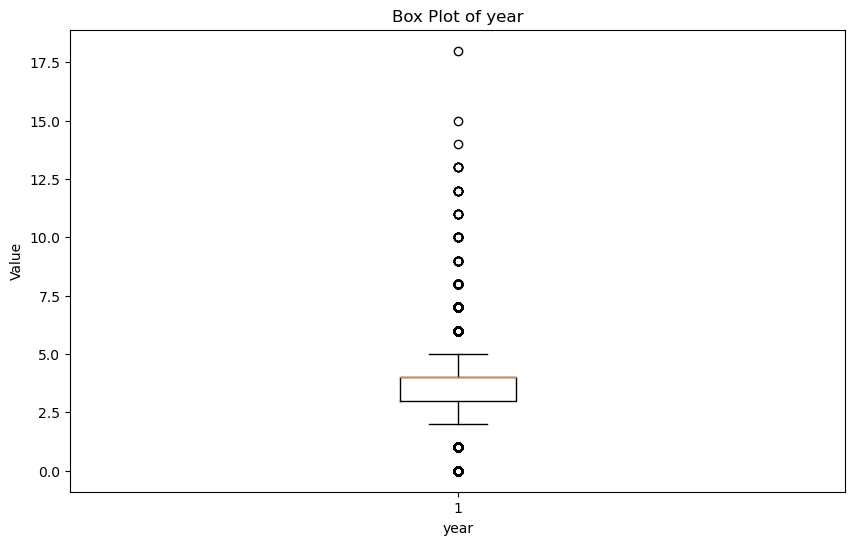

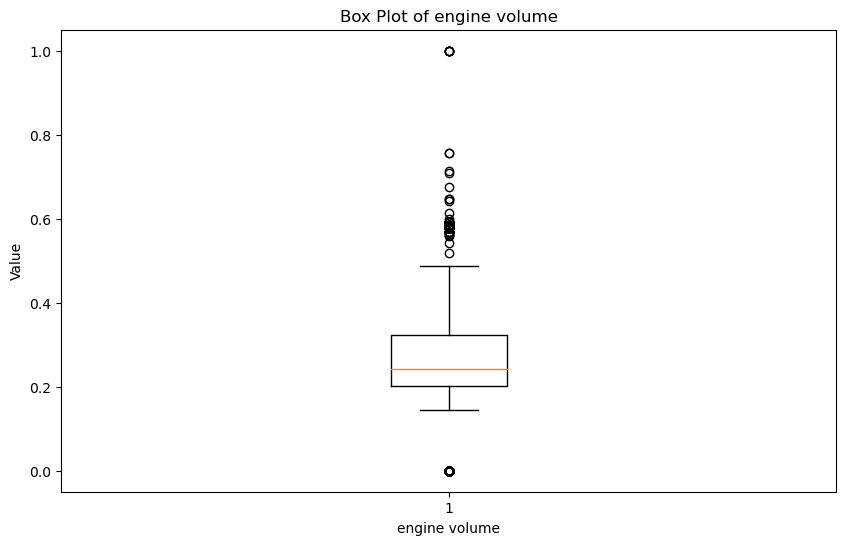

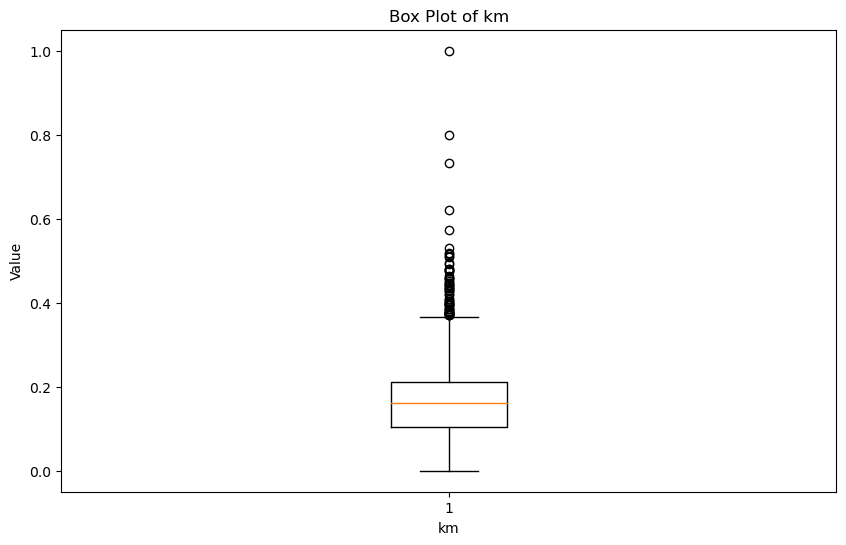

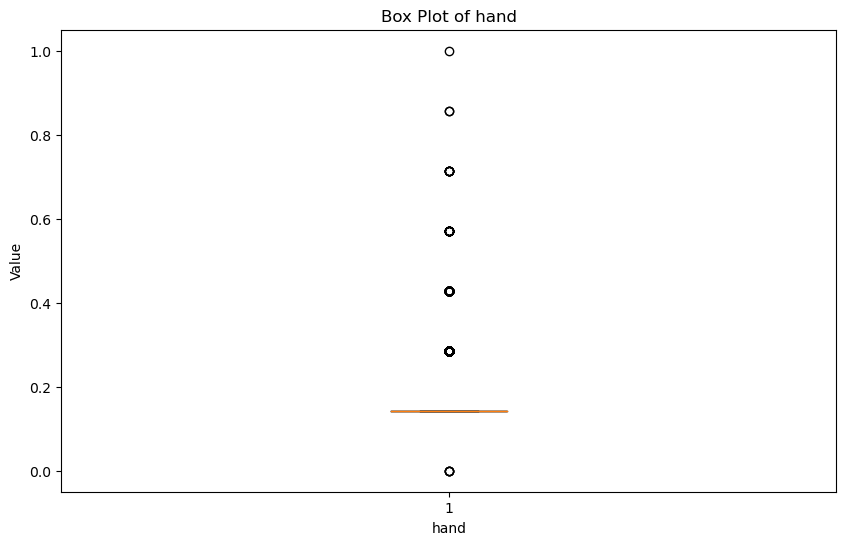

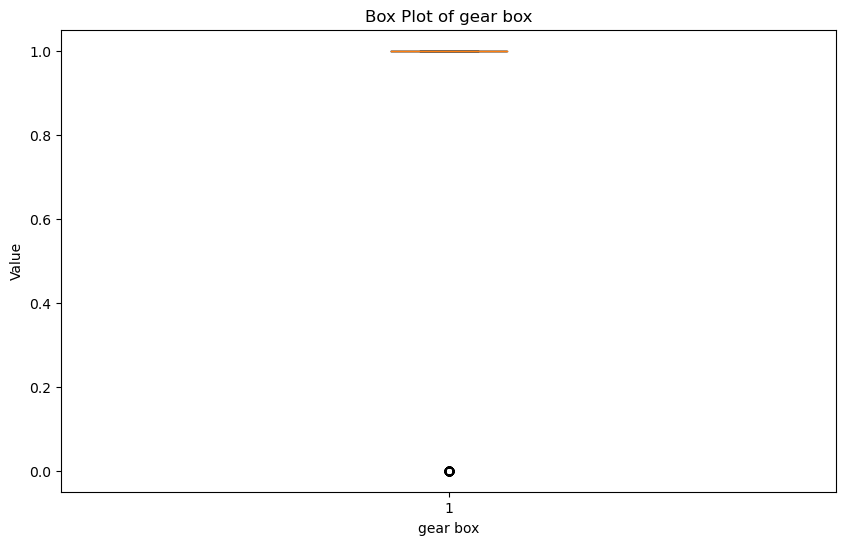

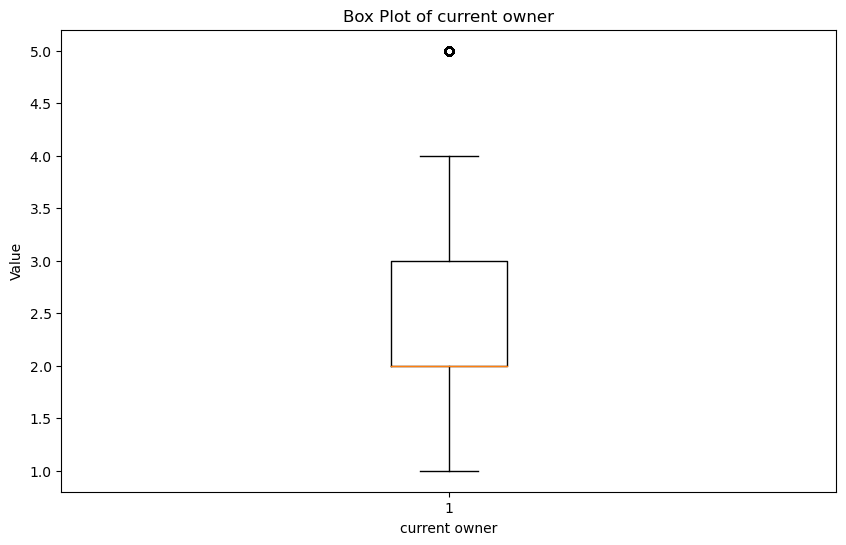

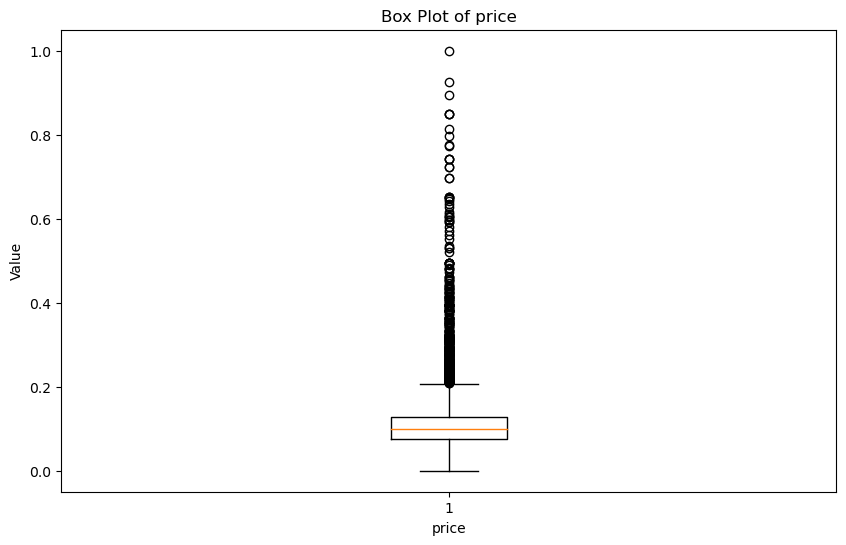

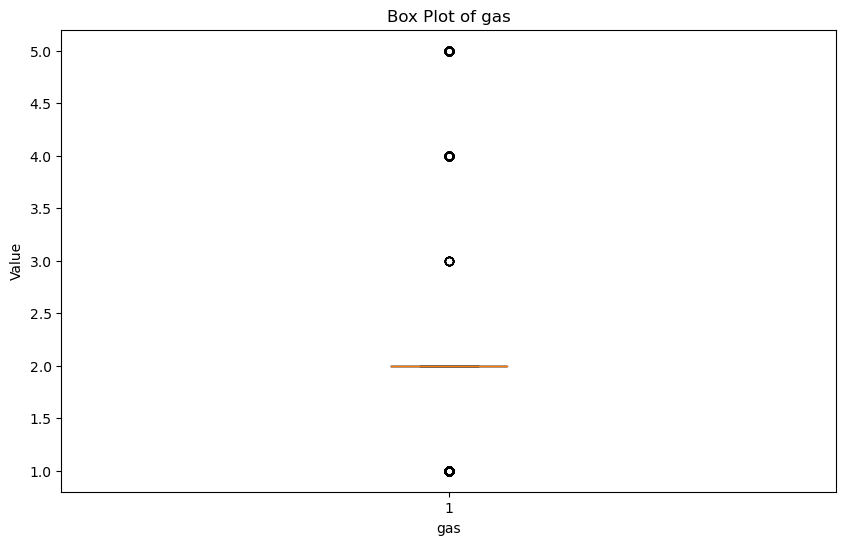

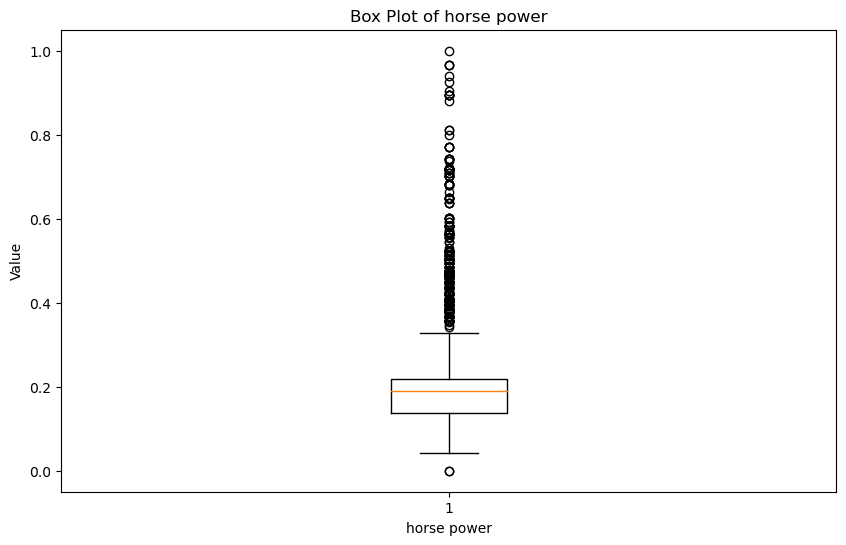

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Select only the numeric columns from the DataFrame
numeric_columns = df.select_dtypes(include='number')

# Iterate over each numeric column and create a box plot
for column in numeric_columns.columns:
    plt.figure()
    plt.boxplot(numeric_columns[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

# Show the box plots
plt.show()

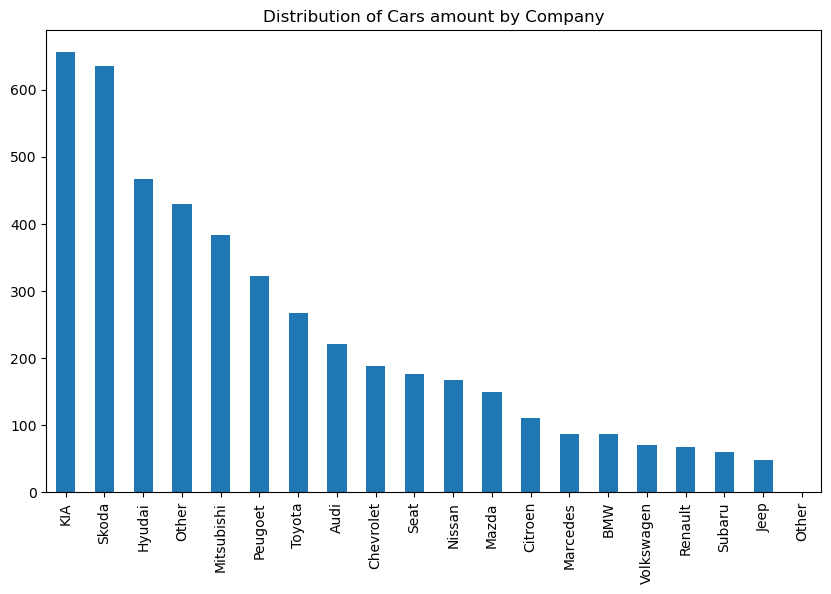

In [104]:
value_counts = df['company'].value_counts()
above_40 = value_counts[value_counts > 40]
below_40 = value_counts[value_counts <= 40]
below_40_sum = below_40.sum()

combined_counts = pd.concat([above_40, pd.Series(below_40_sum, index=['Other'])])

plt.title("Distribution of Cars amount by Company")
combined_counts.plot(kind='bar')
plt.show()


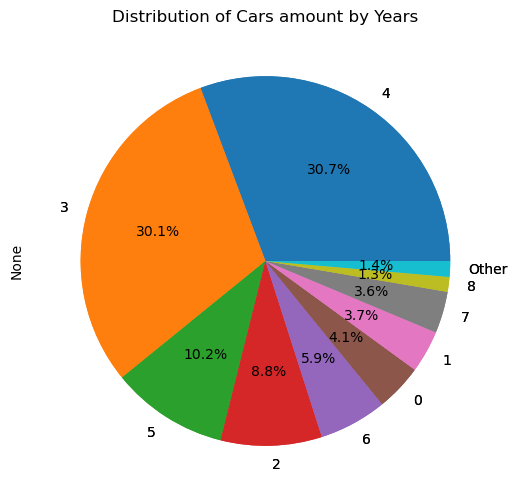

In [105]:
value_counts = df['year'].value_counts()
above_50 = value_counts[value_counts > 50]
below_50 = value_counts[value_counts <= 50]
below_50_sum = below_50.sum()

combined_counts = pd.concat([above_50, pd.Series(below_50_sum, index=['Other'])])
plt.pie(combined_counts, labels=combined_counts.index, autopct='%1.1f%%')

plt.title('Distribution of Cars amount by Years')

combined_counts.plot(kind='pie')
plt.show()


### Two-dimensional visualizations

C:\Users\itayg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



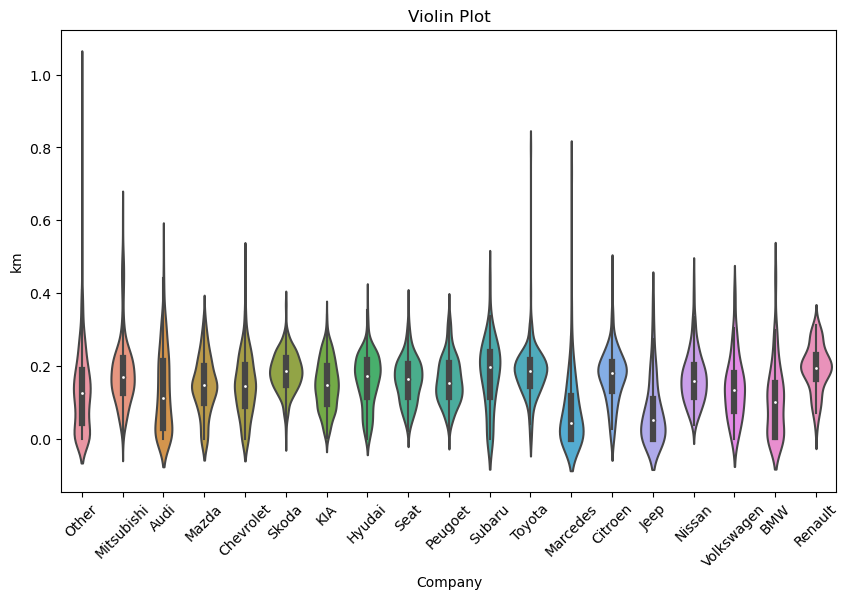

In [110]:
sns.violinplot(df.company, df.km)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlabel('Company')
plt.ylabel('KM')
plt.title('Violin Plot')
plt.show()

It can be seen that the violins are the same in most types of companies, which indicates that the km distribution is normal throughout the df


C:\Users\itayg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



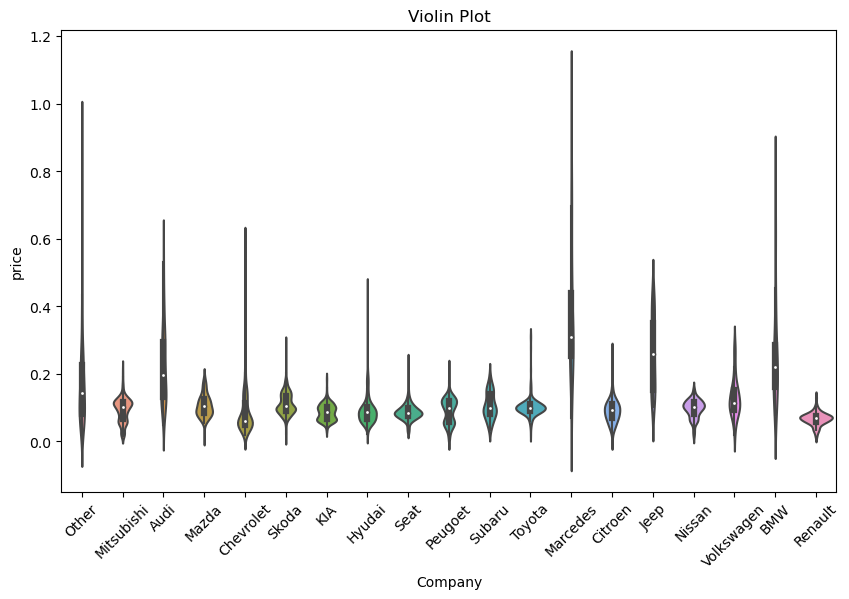

In [113]:
sns.violinplot(df.company, df.price)
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlabel('Company')
plt.ylabel('price')
plt.title('Violin Plot')
plt.show()

Amazing visualization! It can be clearly seen that luxury vehicles (other, Audi, Marcedes, Jeep, BMW) 'last longer'

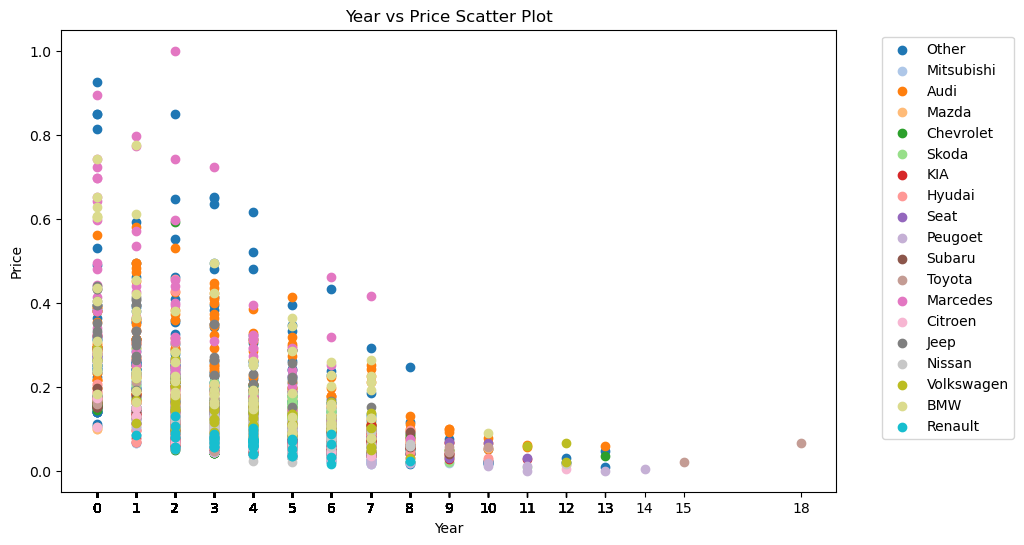

In [116]:
plt.title('Year vs Price Scatter Plot')

# Define the colormap with the most colors
cmap = plt.get_cmap('tab20')

# Get the unique car companies and the number of companies
car_companies = df['company'].unique()
num_companies = len(car_companies)

# Filter car companies with less than or equal to 40 occurrences
value_counts = df['company'].value_counts()
above_40 = value_counts[value_counts > 40]
below_40 = value_counts[value_counts <= 40]
below_40_sum = below_40.sum()
below_40_companies = below_40.index.tolist()

# Replace car companies with less than or equal to 40 occurrences with 'Other'
df['company'] = df['company'].replace(below_40_companies, 'Other')

# Update the unique car companies and the number of companies
car_companies = df['company'].unique()
num_companies = len(car_companies)

# Scatter plot with different colors for each car company
for i, company in enumerate(car_companies):
    company_df = df[df['company'] == company]
    color = cmap(i % cmap.N)  # Cycle through the colormap
    plt.scatter(company_df['year'], company_df['price'], color=color, label=company)

# Customize ticks and labels
plt.ticklabel_format(style='plain')
plt.xticks(df["year"])
plt.xlabel('Year')
plt.ylabel('Price')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

In [126]:
# Create the scatter plot
fig = go.Figure()

for color in df['company'].unique():
    color_data = df[df['company'] == color]
    fig.add_trace(go.Scatter(x=color_data['year'], y=color_data['price'], mode='markers', name=color))

# Calculate the linear regression line
x = df['year']
y = df['price']
linear_coefficients = np.polyfit(x, y, deg=1)
linear_regression = np.poly1d(linear_coefficients)

# Calculate the polynomial regression line
degree = 2
polynomial_coefficients = np.polyfit(x, y, deg=degree)
polynomial_regression = np.poly1d(polynomial_coefficients)

# Generate x-values for the regression lines
x_regression = np.linspace(x.min(), x.max(), 100)
linear_y_regression = linear_regression(x_regression)
polynomial_y_regression = polynomial_regression(x_regression)

# Add the linear regression line to the plot
fig.add_trace(go.Scatter(x=x_regression, y=linear_y_regression, mode='lines', name='Linear Regression'))

# Add the polynomial regression line to the plot
fig.add_trace(go.Scatter(x=x_regression, y=polynomial_y_regression, mode='lines', name='Polynomial Regression'))

# Set the layout and axis labels
fig.update_layout(xaxis_title='Year', yaxis_title='Price', title='Scatter Plot of Price by Year')

# Show the plot
fig.show()


It can be seen that over the years there is a linear drop in the price of the vehicle.
In addition it can be seen that
1. Renault is right on the linear straight line.
2. The slope of a jeep is consistent with the linear descent, and is always above it.
3. Volkswagen, Mazda, Chevy, Skoda, Pegault, Subro are above and below the straight lines nicely.
4. The Audi, Mercedes, BMW are above the straight line and the polynomial.
5. Kia, Nissan, maintains its value and is not affected by the years.
6. Toyota is in a relatively large dispersion.
7. Citroën is consistently under the line.


It is important to note that at first glance it is not clear why the line is so low, only after going through all the companies do you understand why. Visualization can be deceiving! You can also see the distortion created by outliers at the right end of the graph on the polynomial

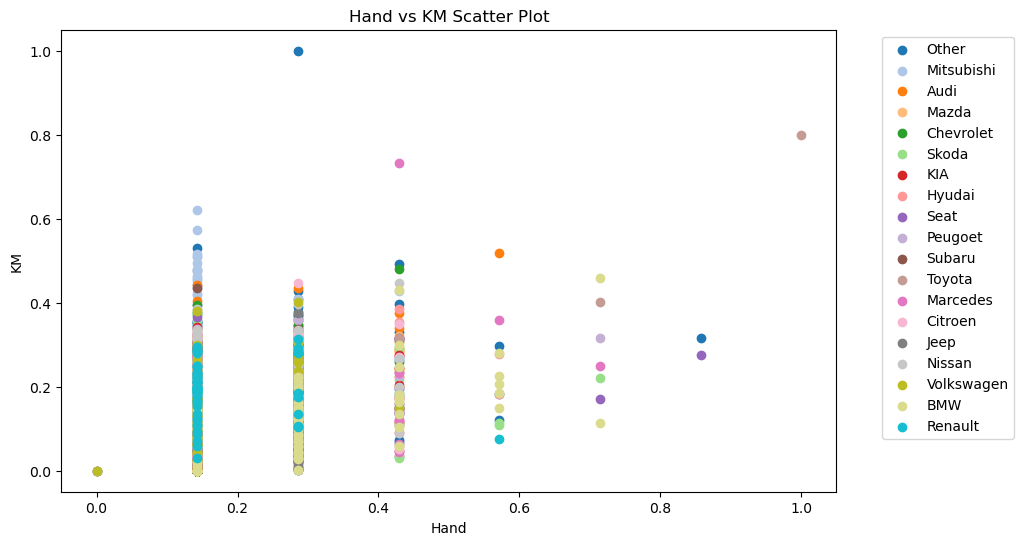

In [29]:
plt.title('Hand vs KM Scatter Plot')

# Define the colormap with the most colors
cmap = plt.get_cmap('tab20')

# Get the unique car companies and the number of companies
car_companies = df['company'].unique()
num_companies = len(car_companies)

# Filter car companies with less than or equal to 40 occurrences
value_counts = df['company'].value_counts()
above_40 = value_counts[value_counts > 40]
below_40 = value_counts[value_counts <= 40]
below_40_sum = below_40.sum()
below_40_companies = below_40.index.tolist()

# Replace car companies with less than or equal to 40 occurrences with 'Other'
df['company'] = df['company'].replace(below_40_companies, 'Other')

# Update the unique car companies and the number of companies
car_companies = df['company'].unique()
num_companies = len(car_companies)

# Scatter plot with different colors for each car company
for i, company in enumerate(car_companies):
    company_df = df[df['company'] == company]
    color = cmap(i % cmap.N)  # Cycle through the colormap
    plt.scatter(company_df['hand'], company_df['km'], color=color, label=company)

# Customize ticks and labels
plt.ticklabel_format(style='plain')
plt.xlabel('Hand')
plt.ylabel('KM')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

Unlike what we expected, it can be seen that there are actually no significant differences in kilometers between each of the different hands of the cars. </br>
Such a figure makes it clear to us the importance of EDA.

### Multi-dimensional visualizations

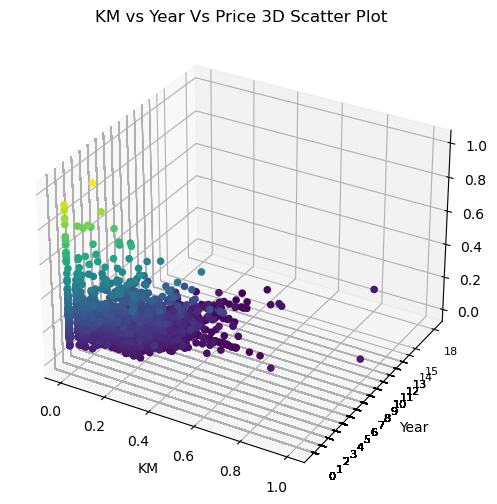

In [127]:
ax = plt.axes(projection='3d')

xdata=df.km
ydata=df.year
zdata=df.price

plt.yticks(df.year)

plt.xlabel('KM')
plt.ylabel('Year')

# Customize font properties of ticks
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=10)

ax.scatter(xdata, ydata, zdata, c=zdata, depthshade=False)
plt.title('KM vs Year Vs Price 3D Scatter Plot')
plt.show()

As we have expected, the lower the kilometers and the higher the year, the higher the price will be.

Now, let's make magic!

In [69]:
import plotly.express as px

fig = px.scatter_3d(df, x='km', y='year', z='price', color='price',
                    symbol='company', opacity=0.8, size_max=10)

fig.update_layout(scene=dict(
    xaxis_title='km',
    yaxis_title='year',
    zaxis_title='Price'
))

fig.show()

In [68]:
import plotly.express as px

fig = px.scatter_3d(df, x='horse power', y='engine volume', z='price', color='price',
                    symbol='company', opacity=0.8, size_max=10)

fig.update_layout(scene=dict(
    xaxis_title='Horse Power',
    yaxis_title='Engine Volume',
    zaxis_title='Price'
))

fig.show()

In [31]:
dataset = df.loc[:,['engine volume', 'hand', 'gear box', 'gas', 'horse power']] #(4591,5)
pca2 = PCA(n_components=2) 
pcComponents = pca2.fit_transform(dataset) #(4591,2)
pca2.explained_variance_ratio_ 

array([0.91551863, 0.03875896])

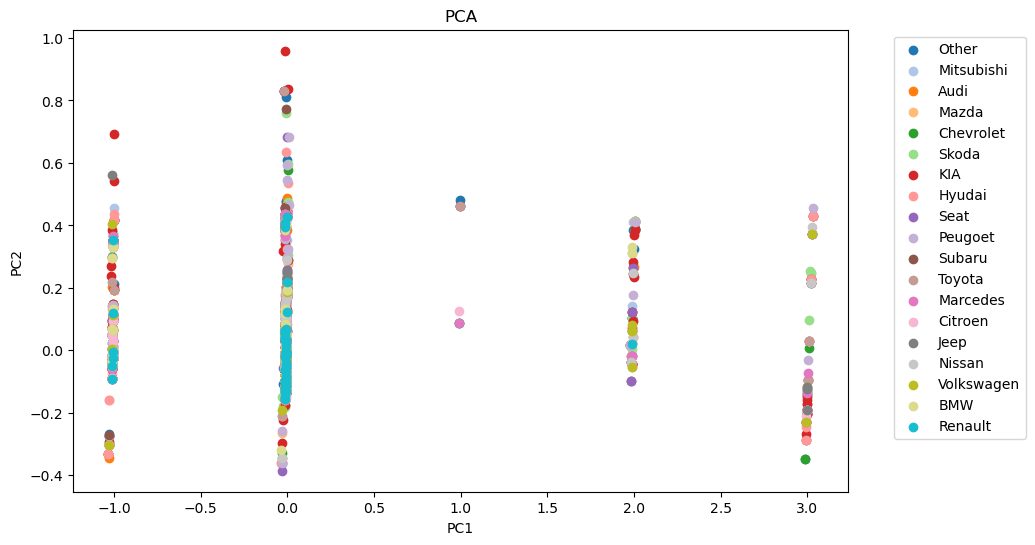

In [32]:
# Filter car companies with less than or equal to 40 occurrences
value_counts = df['company'].value_counts()
above_40 = value_counts[value_counts > 40]
below_40 = value_counts[value_counts <= 40]
below_40_sum = below_40.sum()
below_40_companies = below_40.index.tolist()

# Replace car companies with less than or equal to 40 occurrences with 'Other'
df['company'] = df['company'].replace(below_40_companies, 'Other')

# Extract the required columns for PCA
dataset = df.loc[:, ['engine volume', 'hand', 'gear box', 'gas', 'horse power']]

# Perform PCA
pca2 = PCA(n_components=2)
pcComponents = pca2.fit_transform(dataset)
pca_explained_variance = pca2.explained_variance_ratio_

# Create DataFrame for principal components
principalDf = pd.DataFrame(data=pcComponents, columns=['principal component 1', 'principal component 2'])

# Concatenate principal components with 'company' column
finalDf = pd.concat([principalDf, df[['company']]], axis=1)

# Create the scatter plot
fig = plt.figure()
ax = plt.axes()

# Define the colormap with the most colors
cmap = plt.get_cmap('tab20')

# Get the unique car companies and the number of companies
car_companies = df['company'].unique()

for i, company in enumerate(car_companies):
    company_df = finalDf[finalDf['company'] == company]
    color = cmap(i % cmap.N)  # Cycle through the colormap
    ax.scatter(company_df['principal component 1'], company_df['principal component 2'], color=color, label=company)

plt.xlabel('PC1')
plt.ylabel('PC2')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("PCA")
plt.show()

C:\Users\itayg\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\itayg\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


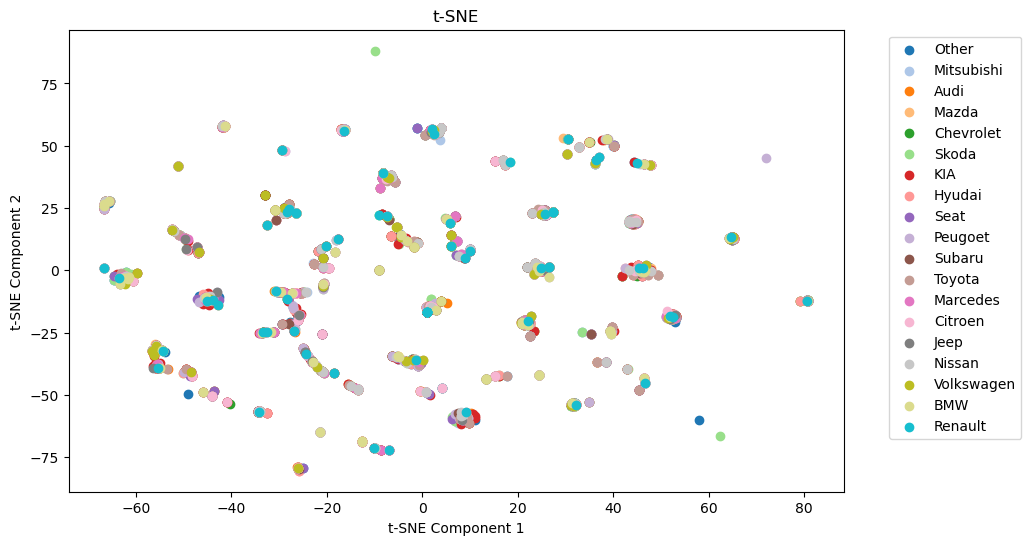

In [36]:
#T-SNE

These numbers mean that the first axis captures more than 99% of the variance, while the second captures less than 1% of the variance. Thus, the two dimensional reduction captures 100 percent of the total variation of the initial data.

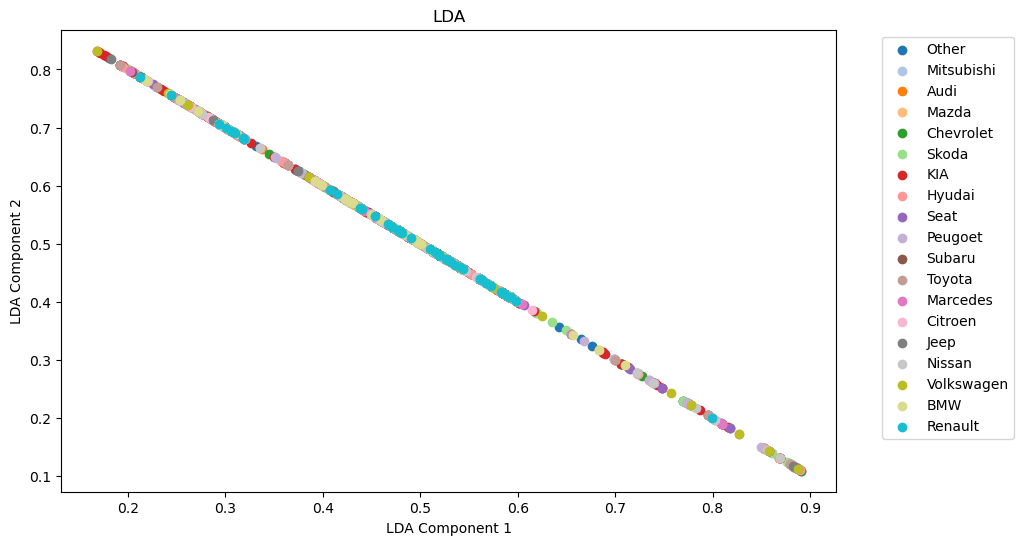

In [37]:
#LDA

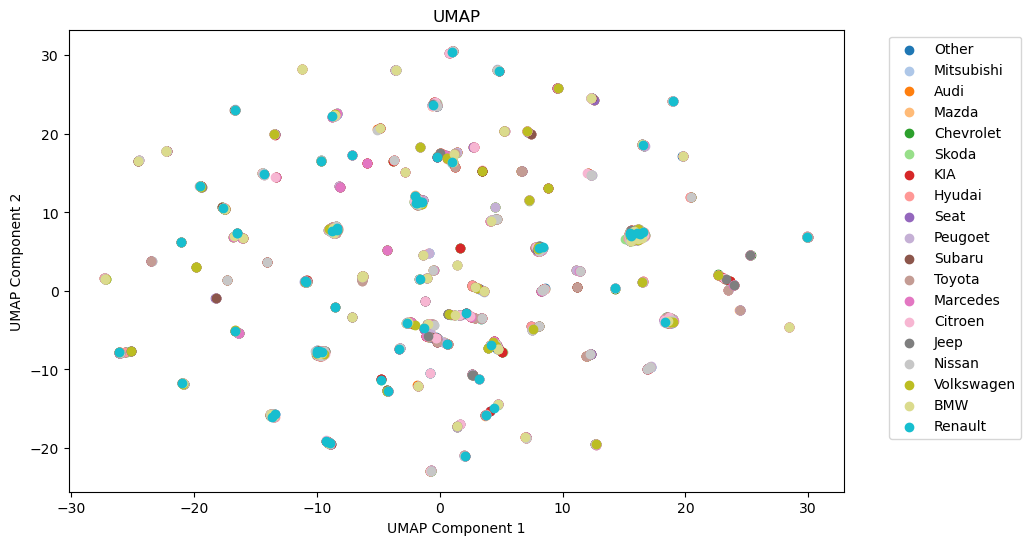

In [92]:
#Umap

As you can see, there is no multi-dimensional visualization that combines the variables in a good way

# Machine Learning

We will try Linear Regression

In [157]:
X = df[["year", "engine volume", "km", "hand", "gear box", "current owner", "gas", "horse power"]]
y = df["price"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a linear regression object
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

LinearRegression()

In [158]:
print("Slope:", lr.coef_)
print("Intercept:", lr.intercept_)
print("R2:", lr.score(X_test, y_test))

Slope: [-0.01738929  0.14902004 -0.12184027  0.05024272 -0.00258259  0.00415379
 -0.00310055  0.45350259]
Intercept: 0.06149513366385696
R2: 0.6657505138570893


In order to make the R2 value higher we will try another option : Nonlinear relationships

In [159]:
# Select the input features and target variable
X = df[["year", "engine volume", "km", "hand", "gear box", "current owner", "gas", "horse power"]]
y = df["price"]

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create polynomial features
degree = 2  # Degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Create a linear regression object
lr = LinearRegression()

# Fit the polynomial regression model on the training data
lr.fit(X_train_poly, y_train)

# Print the R2 score for the test set
r2_score = lr.score(X_test_poly, y_test)
print("R2 score:", r2_score)

R2 score: 0.7629189806647668


#### Now we got an even higher R2 score with over 76%!

In [160]:
#pip install lazypredict

In [ ]:
"""from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Separate the features (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the model performance metrics
print(models)
"""